# Загрузка библиотек

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

# Предъобработка данных

In [93]:
df = pd.read_excel(
    "data/dataset.xlsx",
    sheet_name="Лист1",
)
df

,Номер,Фамилия И.О.,Телефон,База (ПСПбГМУ-1; КДЦ-2),Пол (М-1; Ж-2),Возраст на момент операции(лет),Дата приема,Длительность анамнеза РЩЖ(заб.ЩЖ) до постановки диагноза(лет),Диагноз (ФР-1;ПР-2;НДЦ-3;МР-4;Гюртоклеточная карцинома-5;ПР+МР-6;ПР+ФР-7;ФА-8;Гюртокл.+ПР-9;онкоцитарная-10),Гистология(классический-1;фолликулярный-2;микрокарцинома-3;высококлеточный-4;солидный-5;ФА-6;Уортиноподобный-7),...,Новые узлы (Да-1; Нет-2),Узел (доброкач-1;злокач-2),Размер узла(мм),TI-RADS.1,Bethesda.1,Новые узлы (Да-1; Нет-2).1,Узел (доброкач-1;злокач-2).1,Размер узла(мм).1,TI-RADS.2,Bethesda.2
0,1,Амосова Л.В.,NaN,1.0,2,70.0,10.01.2019,0.35,2.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Асланова Т.И.,NaN,1.0,2,57.0,2019-02-22 00:00:00,0.5,1.0,2,...,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN
2,3,Аушева Р.О.,NaN,1.0,2,54.0,31.07.2018,0.2,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Афанасьев К.М.,NaN,1.0,1,51.0,19.06.18,3,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Ахметов Е.М.,8.911990e+10,1.0,1,50.0,NaN,0.5,2.0,NaN,...,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,259,"Бурова С, Ю,",NaN,1.0,2,55.0,01.11.2022,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,260,"Долматов К, С,",NaN,1.0,1,33.0,17.12.2022,NaN,2.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260,261,"Дружкова А, В,",NaN,1.0,2,47.0,30.08.2022,NaN,2.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,262,"Кашина А, О,",NaN,1.0,2,46.0,15.11.2022,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
cols_to_sum = [
    'Рецидив через 6 месяцев? (Да-1;ремиссия-2)',
    'Рецидив через 1 год? (Да-1; ремиссия-2)',
    'Рецидив через 3 года? (Да-1; ремиссия-2)',
    'Рецидив через 10 лет (Да-1; ремиссия-2)',
    'Рецидив да-1 нет -2'
]
df['Рецидив да-1 нет -2'] = df[cols_to_sum].eq(1).any(axis=1).map({True: 1, False: 0})

In [95]:
cols_to_drop = [
    "Номер",
    "Фамилия И.О.",
    "Телефон",
    "Дата приема",
    "База (ПСПбГМУ-1; КДЦ-2)",
    'Рецидив через 6 месяцев? (Да-1;ремиссия-2)',
    'Рецидив через 1 год? (Да-1; ремиссия-2)',
    'Рецидив через 3 года? (Да-1; ремиссия-2)',
    'Рецидив через 10 лет (Да-1; ремиссия-2)'
]
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')

In [96]:
cols_to_change = [
    "Glut",
    "BRAF",
    "gBRAFN.1"
]
for col in cols_to_change:
    df[col] = df[col].apply(lambda x: str(x).strip())

In [97]:
def clean_duration(val):
    if pd.isna(val):
        return np.nan
    val_str = str(val).lower().replace(',', '.')

    match = re.findall(r"[\d\.]+", val_str)
    if not match:
        try:
            return float(val_str)
        except ValueError:
            return np.nan

    num = float(match[0])

    if 'год' in val_str or 'лет' in val_str:
        return num
    elif 'месяц' in val_str:
        return num / 12
    elif 'недел' in val_str:
        return num / 52
    elif 'день' in val_str:
        return num / 365

    try:
        return float(val_str)
    except ValueError:
        return num
df['Длительность анамнеза РЩЖ(заб.ЩЖ) до постановки диагноза(лет)'] = df['Длительность анамнеза РЩЖ(заб.ЩЖ) до постановки диагноза(лет)'].apply(clean_duration)

In [98]:
def clean_lu(val):
    if pd.isna(val) or val in ['?', 'паратрахельные', 'шейные', 'средостения']:
        return np.nan
    try:
        return float(val)
    except:
        return np.nan
df['Количество пораженных ЛУ'] = df['Количество пораженных ЛУ'].apply(clean_lu)

## One-hot encoding

In [99]:
for col in df.select_dtypes(include=['object']).columns:
    if df[col].nunique() < 50:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col, dummy_na=True)], axis=1)
        df = df.drop(columns=[col])
    else:
        df = df.drop(columns=[col])

## Удаление выбросов

In [100]:
df = df.drop_duplicates().copy()

num_cols = df.select_dtypes(include="number").columns

Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outlier_share_by_col = ((df[num_cols] < lower) | (df[num_cols] > upper)).mean(axis=0)

cols_to_drop = outlier_share_by_col[outlier_share_by_col > 0.30].index.tolist()
df = df.drop(columns=cols_to_drop)

print(f"Удалено {len(cols_to_drop)} столбцов с >30% выбросов:")
print(cols_to_drop)
print("Результирующее количество строк:", df.shape)


Удалено 0 столбцов с >30% выбросов:
[]
Результирующее количество строк: (263, 769)


## Замена на пропусков

In [101]:
numerical_cols = df.select_dtypes(include=np.number).columns
df = df.drop(columns=df[numerical_cols].columns[df[numerical_cols].isnull().all()])
numerical_cols = df.select_dtypes(include=np.number).columns

imputer = SimpleImputer(strategy='mean')

df[numerical_cols] = imputer.fit_transform(df[numerical_cols])
df.isnull().sum()

Пол (М-1; Ж-2)                                                                                                  0
Возраст на момент операции(лет)                                                                                 0
Длительность анамнеза РЩЖ(заб.ЩЖ) до постановки диагноза(лет)                                                   0
Диагноз (ФР-1;ПР-2;НДЦ-3;МР-4;Гюртоклеточная карцинома-5;ПР+МР-6;ПР+ФР-7;ФА-8;Гюртокл.+ПР-9;онкоцитарная-10)    0
N(0-нет mts; 1-1; 1a-2; 1b-3; x-4)                                                                              0
                                                                                                               ..
TI-RADS.2_1(правая доля)                                                                                        0
TI-RADS.2_2(правая доля)                                                                                        0
TI-RADS.2_3                                                                             

In [102]:
target_col = "Рецидив да-1 нет -2"

class_counts = df[target_col].value_counts(dropna=False)
class_share = (class_counts / len(df) * 100).round(2)

pd.DataFrame({"count": class_counts, "percent": class_share})

,count,percent
Рецидив да-1 нет -2,,
0.0,208,79.09
1.0,55,20.91


# Обучение моделей

In [ ]:
target_col = "Рецидив да-1 нет -2"

if target_col not in df.columns:
    raise KeyError(f"Target column not found in df: {target_col}")

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Логистическая регрессия

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

logreg_model = LogisticRegression(random_state=42, max_iter=1000)

param_dist = {
    'C': np.logspace(-3, 3, 10), 
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['saga'],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

f1_scorer = make_scorer(f1_score)

rand_search = RandomizedSearchCV(
    estimator=logreg_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring=f1_scorer,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rand_search.fit(X_train_res, y_train_res)

best_logreg = rand_search.best_estimator_

y_pred = best_logreg.predict(X_test_scaled)
f1_final = f1_score(y_test, y_pred)

print("\n--- Результаты Logistic Regression с RandomizedSearch + SMOTE ---")
print(f"Лучшие параметры: {rand_search.best_params_}")
print(f"F1-Score на тестовом наборе: {f1_final:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Результаты Logistic Regression с RandomizedSearch + SMOTE ---
Лучшие параметры: {'solver': 'saga', 'penalty': 'l2', 'l1_ratio': 0.25, 'C': np.float64(0.021544346900318832)}
F1-Score на тестовом наборе: 0.8421


## Градиентный бустинг

In [117]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

gb_model = GradientBoostingClassifier(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

f1_scorer = make_scorer(f1_score)

rand_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring=f1_scorer,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rand_search.fit(X_train_res, y_train_res)

best_gb = rand_search.best_estimator_

y_pred = best_gb.predict(X_test_scaled)
f1_final = f1_score(y_test, y_pred)

print("\n--- Результаты Gradient Boosting с RandomizedSearch + SMOTE ---")
print(f"Лучшие параметры: {rand_search.best_params_}")
print(f"F1-Score на тестовом наборе: {f1_final:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.2, max_depth=6, max_features=sqrt, n_estimators=500, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=6, max_features=sqrt, n_estimators=500, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=6, max_features=sqrt, n_estimators=500, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=6, max_features=sqrt, n_estimators=500, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=6, max_features=sqrt, n_estimators=500, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=3, max_features=log2, n_estimators=700, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, max_features=log2, n_estimators=700, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, max_features=log2, n_estimators=700, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=

## XGBClassifier

In [115]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score, make_scorer
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

xgb_model = XGBClassifier(
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss'
)

param_dist = {
    'n_estimators': [200, 300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [4, 5, 6, 7, 9],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 1, 10]
}

f1_scorer = make_scorer(f1_score)

rand_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring=f1_scorer,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rand_search.fit(X_train_res, y_train_res)

best_xgb = rand_search.best_estimator_

y_pred = best_xgb.predict(X_test_scaled)
f1_final = f1_score(y_test, y_pred)

print("\n--- Результаты XGBoost с RandomizedSearch + SMOTE ---")
print(f"Лучшие параметры: {rand_search.best_params_}")
print(f"F1-Score на тестовом наборе: {f1_final:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=700, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=700, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=700, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=700, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=700, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=200, reg_alpha=0.01, reg_lambda=1, subsample=0.6; total time=  

In [112]:
best_xgb = XGBClassifier(
    subsample=0.8,
    reg_lambda=0.1,
    reg_alpha=1,
    n_estimators=200,
    max_depth=9,
    learning_rate=0.05,
    gamma=0,
    colsample_bytree=0.6,
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss'
)
best_xgb.fit(X_train_res, y_train_res)

y_pred = best_xgb.predict(X_test_scaled)
f1_final = f1_score(y_test, y_pred)

print("\n--- Результаты лучшего XGBoost с RandomizedSearch + SMOTE ---")
print(f"F1-Score на тестовом наборе: {f1_final:.4f}")


--- Результаты лучшего XGBoost с RandomizedSearch + SMOTE ---
F1-Score на тестовом наборе: 0.9524


In [109]:
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_xgb_cls.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\n--- Важность признаков (Embedded метод) ---")
print(feature_importances)


--- Важность признаков (Embedded метод) ---
                                               feature  importance
577             Жировой гепатоз печени (Да-1; Нет-2)_2    0.063326
33                                         Na(ммоль/л)    0.040470
638  послеоперац. N (0-нет mts; 1-1; 1a-2; 1b-3; x-...    0.036693
19                                Окружность талии (с)    0.035872
134                   ТГ(нг/мл)до операции пунктат_nan    0.035351
..                                                 ...         ...
295                           Рост(см) до операции_172    0.000000
296                           Рост(см) до операции_174    0.000000
297                           Рост(см) до операции_176    0.000000
298                           Рост(см) до операции_177    0.000000
764                                      TI-RADS.2_nan    0.000000

[765 rows x 2 columns]


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    f1_score,
    roc_auc_score
)
import pandas as pd

def get_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    except AttributeError:
        auc = None

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else None  # Recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else None
    precision = precision_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    return {
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Precision": precision,
        "Accuracy": accuracy,
        "F1-score": f1,
        "ROC AUC": auc
    }

models = {
    "GradientBoostingClassifier": best_gb,
    "XGBClassifier": best_xgb,
    "LogisticRegression": best_logreg
}

# -----------------------------
# Сбор метрик
# -----------------------------
results = {}
for name, mdl in models.items():
    results[name] = get_metrics(mdl, X_test_scaled, y_test)

# -----------------------------
# Преобразуем в DataFrame
# -----------------------------
df_results = pd.DataFrame(results).T
df_results


,Sensitivity,Specificity,Precision,Accuracy,F1-score,ROC AUC
GradientBoostingClassifier,0.909091,0.97619,0.909091,0.962264,0.909091,0.995671
XGBClassifier,0.909091,1.00000,1.000000,0.981132,0.952381,0.997835
LogisticRegression,0.727273,1.00000,1.000000,0.943396,0.842105,0.956710


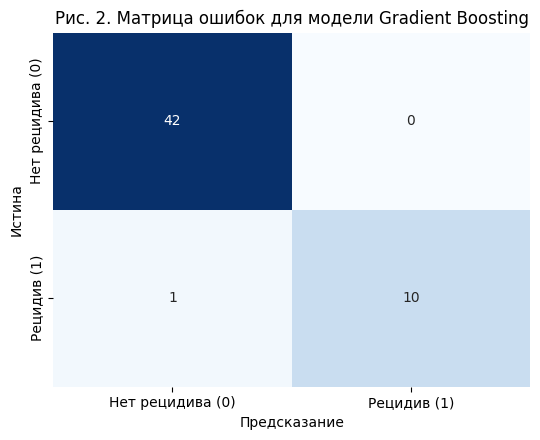

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

if "best_gb_cls" not in globals():
    raise ValueError("best_gb_cls не найден. Сначала обучи GradientBoostingClassifier (ячейка с gb_grid_search).")
if "X_test" not in globals() or "y_test" not in globals():
    raise ValueError("X_test/y_test не найдены. Запусти ячейку с train_test_split перед построением матрицы ошибок.")

y_pred_gb = best_xgb.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_gb)

plt.figure(figsize=(5.5, 4.5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Нет рецидива (0)", "Рецидив (1)"],
    yticklabels=["Нет рецидива (0)", "Рецидив (1)"]
)
plt.xlabel("Предсказание")
plt.ylabel("Истина")
plt.title("Рис. 2. Матрица ошибок для модели Gradient Boosting")
plt.tight_layout()
plt.show()